In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
run = api.run('druhe/gw-src/16pgb80c')

In [6]:
config = unflatten(run.config)

In [7]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [8]:
sb_weight = config['model']['sb_weight']

In [9]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [11]:
tempdir = tempfile.TemporaryDirectory()

In [12]:
ckpt = checkpoints[0]

In [13]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [14]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, dataset=dataset, sb_weight=sb_weight, flows=flows)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmp6ph5344i
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmp6ph5344i/_remote_module_non_sriptable.py


In [15]:
dataset.gw_train_batch_size = 32
dataset.sel_train_batch_size = 32

In [16]:
gw_loader, sel_loader  = dataset.train_dataloader()

In [17]:
import hamiltorch

from torch.nn.utils import _stateless


In [18]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [19]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


params_flat = params_flat.squeeze()

In [20]:
model=model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [21]:
fmodel = hamiltorch.util.make_functional(model)

In [22]:
gw_iter = iter(gw_loader)
sel_iter = iter(sel_loader)

In [23]:
def log_prob(params, y=None):
    global gw_iter
    global sel_iter
    try:
        gw_batch = next(gw_iter)
        sel_batch = next(sel_iter)
    except StopIteration:
        gw_iter = iter(gw_loader)
        sel_iter = iter(sel_loader)
        gw_batch = next(gw_iter)
        sel_batch = next(sel_iter)

    gw_batch[0] = gw_batch[0].double()
    sel_batch[0] = sel_batch[0].double()
    
    prior = torch.distributions.Normal(params_init, 1).log_prob(params)

    params = unflatten_params(params, indices, model)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, (gw_batch, sel_batch))    
    ll = prior.sum() / len(out) + out.mean()
#     print(out.mean().item())
    return ll




In [24]:
N = 300
burn = 200
N_nuts = N + burn
step_size = 1e-4
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Step: 0, Current Hamiltoninian: 34.15228055364747, Proposed Hamiltoninian: 38.19383593660571
REJECT
Step: 1, Current Hamiltoninian: 27.668798859162465, Proposed Hamiltoninian: 39.809412760257295
REJECT
Step: 2, Current Hamiltoninian: 30.75248054735722, Proposed Hamiltoninian: 30.72614350778217
Accept rho: 0.0
Step: 3, Current Hamiltoninian: 34.822659640053374, Proposed Hamiltoninian: 34.94708653795609
Accept rho: -0.12442689790271544
Step: 4, Current Hamiltoninian: 26.364190753693798, Proposed Hamiltoninian: 26.521158448428537
Accept rho: -0.15696769473473893
Step: 5, Current Hamiltoninian: 21.167317690338237, Proposed Hamiltoninian: 21.314464981070785
Accept rho: -0.14714729073254773
Step: 6, Current Hamiltoninian: 35.957468616229114, Proposed Hamiltoninian: 36.021802604305826
Accept rho: -0.06433398807671153
Step: 7, Current Hamiltoninian: 25.807735180029027, Proposed 

Step: 70, Current Hamiltoninian: 30.251170336962723, Proposed Hamiltoninian: 30.212515540410635
Accept rho: 0.0
Step: 71, Current Hamiltoninian: 29.850543025915876, Proposed Hamiltoninian: 29.917327920903844
Accept rho: -0.06678489498796836
Step: 72, Current Hamiltoninian: 23.946043281596253, Proposed Hamiltoninian: 26.318520289917252
REJECT
Step: 73, Current Hamiltoninian: 28.763760510655025, Proposed Hamiltoninian: 28.884639800530316
Accept rho: -0.1208792898752904
Step: 74, Current Hamiltoninian: 28.714193997234858, Proposed Hamiltoninian: 28.502283476019464
Accept rho: 0.0
Step: 75, Current Hamiltoninian: 27.379791078029292, Proposed Hamiltoninian: 27.698187176886933
REJECT
Step: 76, Current Hamiltoninian: 27.20515488383605, Proposed Hamiltoninian: 27.43073470666682
Accept rho: -0.22557982283076683
Step: 77, Current Hamiltoninian: 25.540505397177185, Proposed Hamiltoninian: 25.729187478040732
Accept rho: -0.18868208086354699
Step: 78, Current Hamiltoninian: 28.938797115525453, Prop

Step: 141, Current Hamiltoninian: 24.586972142220787, Proposed Hamiltoninian: 24.829601009232093
Accept rho: -0.24262886701130526
Step: 142, Current Hamiltoninian: 28.000614948449698, Proposed Hamiltoninian: 28.23093592966412
Accept rho: -0.23032098121442246
Step: 143, Current Hamiltoninian: 25.89851432878597, Proposed Hamiltoninian: 25.882522215070026
Accept rho: 0.0
Step: 144, Current Hamiltoninian: 28.810594743209204, Proposed Hamiltoninian: 30.218478770114572
REJECT
Step: 145, Current Hamiltoninian: 41.65638938235713, Proposed Hamiltoninian: 41.557743571760795
Accept rho: 0.0
Step: 146, Current Hamiltoninian: 33.37929551346981, Proposed Hamiltoninian: 33.37096092082318
Accept rho: 0.0
Step: 147, Current Hamiltoninian: 28.927944030288643, Proposed Hamiltoninian: 28.75310726353141
Accept rho: 0.0
Step: 148, Current Hamiltoninian: 34.02413538329128, Proposed Hamiltoninian: 34.38607800244225
REJECT
Step: 149, Current Hamiltoninian: 39.017689094443504, Proposed Hamiltoninian: 37.9871597

Step: 212, Current Hamiltoninian: 35.1289156092426, Proposed Hamiltoninian: 35.245088910963474
Accept rho: -0.11617330172087748
Step: 213, Current Hamiltoninian: 31.640013301520646, Proposed Hamiltoninian: 32.74498065628707
REJECT
Step: 214, Current Hamiltoninian: 33.642280096639624, Proposed Hamiltoninian: 34.14013345876731
Accept rho: -0.4978533621276853
Step: 215, Current Hamiltoninian: 30.88717684013649, Proposed Hamiltoninian: 30.744358706106624
Accept rho: 0.0
Step: 216, Current Hamiltoninian: 27.332143485929535, Proposed Hamiltoninian: 27.641265665769872
Accept rho: -0.30912217984033674
Step: 217, Current Hamiltoninian: 29.335254912114944, Proposed Hamiltoninian: 28.21665913662325
Accept rho: 0.0
Step: 218, Current Hamiltoninian: 21.528354546432794, Proposed Hamiltoninian: 21.374034482084674
Accept rho: 0.0
Step: 219, Current Hamiltoninian: 24.30570513348066, Proposed Hamiltoninian: 24.02282741525182
Accept rho: 0.0
Step: 220, Current Hamiltoninian: 28.710678147118166, Proposed 

Step: 281, Current Hamiltoninian: 34.16949566057128, Proposed Hamiltoninian: 34.154534943934244
Accept rho: 0.0
Step: 282, Current Hamiltoninian: 32.76187656068436, Proposed Hamiltoninian: 32.61705173389113
Accept rho: 0.0
Step: 283, Current Hamiltoninian: 24.413488665195, Proposed Hamiltoninian: 24.397166749665622
Accept rho: 0.0
Step: 284, Current Hamiltoninian: 25.15601621276969, Proposed Hamiltoninian: 25.190628450860597
Accept rho: -0.034612238090907965
Step: 285, Current Hamiltoninian: 35.24642378825734, Proposed Hamiltoninian: 35.556924270267146
Accept rho: -0.3105004820098074
Step: 286, Current Hamiltoninian: 23.387478638903872, Proposed Hamiltoninian: 23.352153121289703
Accept rho: 0.0
Step: 287, Current Hamiltoninian: 30.18241945964537, Proposed Hamiltoninian: 30.21815056673791
Accept rho: -0.03573110709254124
Step: 288, Current Hamiltoninian: 25.623774568341283, Proposed Hamiltoninian: 25.77347043698491
Accept rho: -0.14969586864362583
Step: 289, Current Hamiltoninian: 27.48

Step: 350, Current Hamiltoninian: 29.30368285273272, Proposed Hamiltoninian: 29.895524682399582
Accept rho: -0.5918418296668619
Step: 351, Current Hamiltoninian: 32.78617924315039, Proposed Hamiltoninian: 32.77802450111891
Accept rho: 0.0
Step: 352, Current Hamiltoninian: 24.945912839729143, Proposed Hamiltoninian: 25.217964660933312
Accept rho: -0.27205182120416893
Step: 353, Current Hamiltoninian: 29.256706183287157, Proposed Hamiltoninian: 29.190422272070638
Accept rho: 0.0
Step: 354, Current Hamiltoninian: 31.409762285975713, Proposed Hamiltoninian: 31.8043736715061
Accept rho: -0.39461138553038566
Step: 355, Current Hamiltoninian: 36.35942462407524, Proposed Hamiltoninian: 36.44587285929073
REJECT
Step: 356, Current Hamiltoninian: 32.18178723883214, Proposed Hamiltoninian: 31.81223686689638
Accept rho: 0.0
Step: 357, Current Hamiltoninian: 23.775948985294768, Proposed Hamiltoninian: 23.996233894433992
REJECT
Step: 358, Current Hamiltoninian: 24.065101248773317, Proposed Hamiltonin

Step: 421, Current Hamiltoninian: 27.974469656316828, Proposed Hamiltoninian: 28.002928326324405
Accept rho: -0.02845867000757707
Step: 422, Current Hamiltoninian: 31.8502206763007, Proposed Hamiltoninian: 32.3047345212144
Accept rho: -0.4545138449136985
Step: 423, Current Hamiltoninian: 29.353049581364978, Proposed Hamiltoninian: 30.249023483974874
REJECT
Step: 424, Current Hamiltoninian: 31.243229941503678, Proposed Hamiltoninian: 32.52143889317228
REJECT
Step: 425, Current Hamiltoninian: 24.788902342139266, Proposed Hamiltoninian: 24.807145191618787
Accept rho: -0.018242849479520373
Step: 426, Current Hamiltoninian: 26.31402751585351, Proposed Hamiltoninian: 25.913283116999445
Accept rho: 0.0
Step: 427, Current Hamiltoninian: 29.741776425144245, Proposed Hamiltoninian: 29.958611563506665
Accept rho: -0.21683513836241985
Step: 428, Current Hamiltoninian: 33.25546482993747, Proposed Hamiltoninian: 32.72248851209358
Accept rho: 0.0
Step: 429, Current Hamiltoninian: 29.21548552718381, P

Step: 492, Current Hamiltoninian: 27.889076730812768, Proposed Hamiltoninian: 27.91802941572088
Accept rho: -0.028952684908112758
Step: 493, Current Hamiltoninian: 36.56902933251631, Proposed Hamiltoninian: 36.37470520625421
Accept rho: 0.0
Step: 494, Current Hamiltoninian: 21.061285272405527, Proposed Hamiltoninian: 21.151718749477688
REJECT
Step: 495, Current Hamiltoninian: 28.891630418691534, Proposed Hamiltoninian: 29.161306767403104
Accept rho: -0.2696763487115703
Step: 496, Current Hamiltoninian: 28.985735690749735, Proposed Hamiltoninian: 29.354442301492462
Accept rho: -0.36870661074272704
Step: 497, Current Hamiltoninian: 24.76737448532792, Proposed Hamiltoninian: 24.62461603629621
Accept rho: 0.0
Step: 498, Current Hamiltoninian: 24.778675801238027, Proposed Hamiltoninian: 24.90981268393109
REJECT
Step: 499, Current Hamiltoninian: 38.089515840463136, Proposed Hamiltoninian: 38.34122028982885
Accept rho: -0.251704449365711
0d:00:05:15 | 0d:00:00:00 | #################### | 500/

In [27]:
samples = torch.stack(samples)

In [31]:
(gw_batch,) = next(gw_iter)


In [37]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

if dataset.has_normalization:
    raise NotImplementedError
    x, y = dataset.normalize_forward(x, y)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z], axis=-1)


In [65]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [76]:
with torch.no_grad():
    logprob = functional_call(model, params_init)
prob = logprob.exp().view(*resolutions)
pm1m2 = prob.sum(-1)

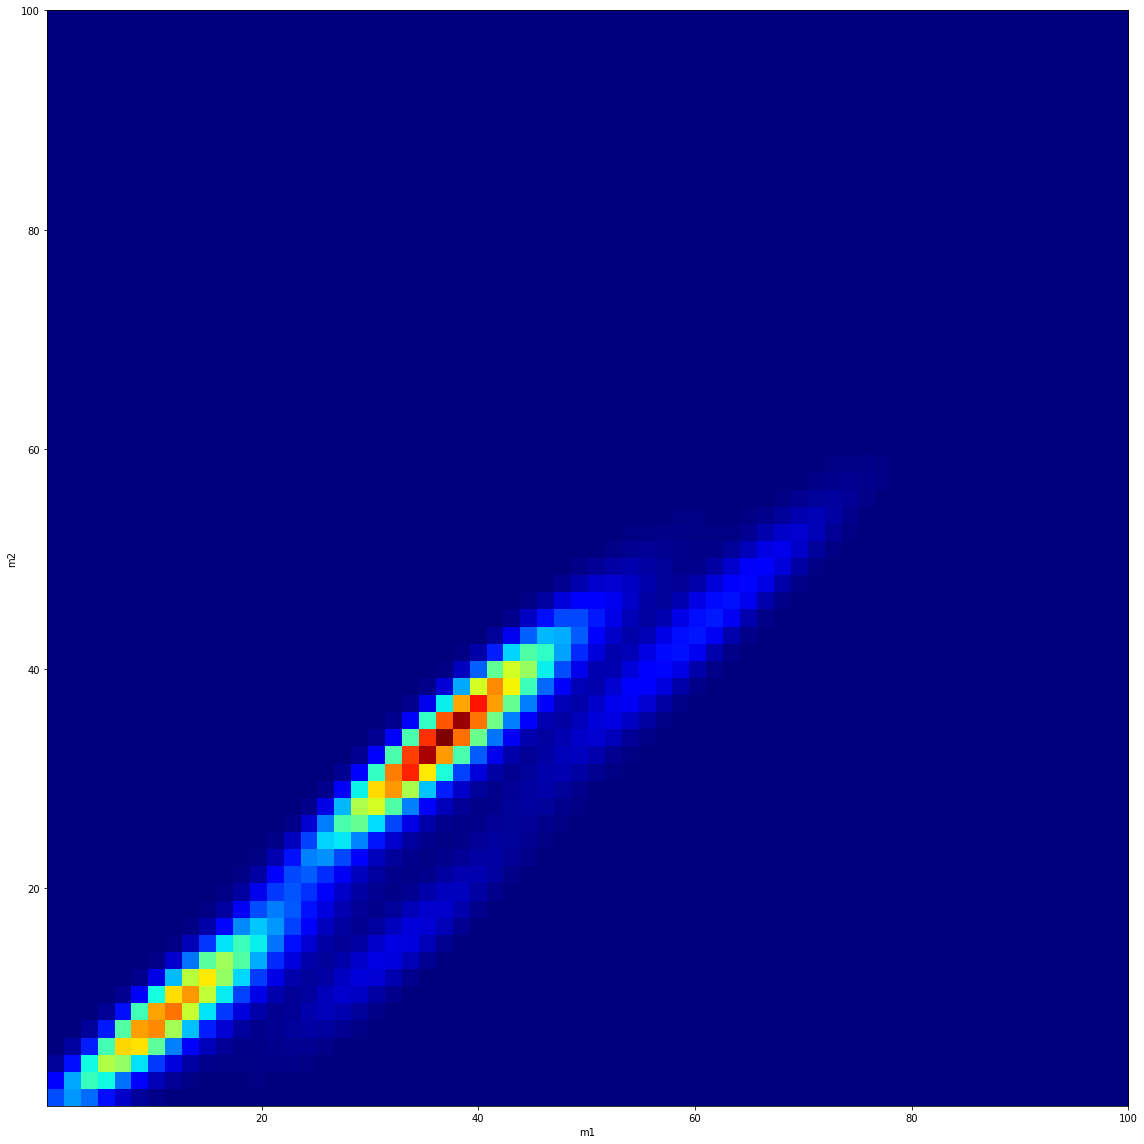

In [78]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[0][0],
        axes[0][-1],
        axes[1][0],
        axes[1][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[0])  # origin='lower' changes the order
plt.ylabel(axes_names[1])
plt.tight_layout()

In [79]:
probs = []
for sample in samples:
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions)
    probs.append(prob)

In [80]:
probs = torch.stack(probs)

In [85]:
probs.shape

torch.Size([300, 64, 64, 64])

In [97]:
m1 = probs.sum((2, 3)).numpy()

In [98]:
m1_med = np.median(m1, axis=0)

In [101]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 0.1)

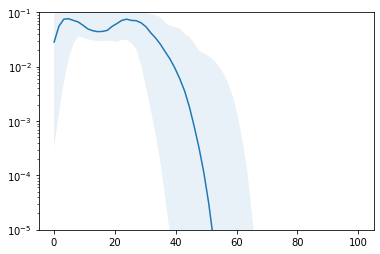

In [107]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 1e-1))